In [15]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img,img_to_array,array_to_img
from keras.layers import Input, Conv2D, Flatten, MaxPooling2D, Dense, BatchNormalization, DepthwiseConv2D, LeakyReLU, Add, GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from skimage.transform import resize
from PIL import Image, ImageOps

import glob, os, random

In [16]:
base_path = 'Images/Train/'

img_list = glob.glob(os.path.join(base_path, '*/*.jpg'))

print(len(img_list))

4559


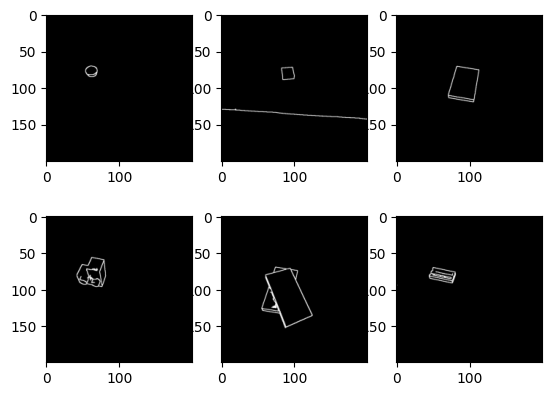

In [17]:
for i, img_path in enumerate(random.sample(img_list, 6)):
    img = load_img(img_path)
    
    img = img_to_array(img, dtype=np.uint8)
    
    old_size = img.shape[:2]
    ratio = 200. / max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    
    img = resize(img, output_shape=new_size, mode='edge', preserve_range=True).astype(np.uint8)
    
    delta_w = 200 - new_size[1]
    delta_h = 200 - new_size[0]
    padding = ((delta_h//2, delta_h-(delta_h//2)), (delta_w//2, delta_w-(delta_w//2)), (0, 0))
    
    img = np.pad(img, padding, 'edge')

    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze())

In [18]:
def resize_pad(img):
    old_size = img.shape[:2]
    ratio = 200. / max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    
    img = resize(img, output_shape=new_size, mode='edge', preserve_range=True)
    
    delta_w = 200 - new_size[1]
    delta_h = 200 - new_size[0]
    padding = ((delta_h//2, delta_h-(delta_h//2)), (delta_w//2, delta_w-(delta_w//2)), (0, 0))
    
    img = np.pad(img, padding, 'edge')
    
    return img

def preprocessing_train(x):
    x = resize_pad(x)
    return x

def preprocessing_val(x):
    x = resize_pad(x)
    return x

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocessing_train,
    rescale=1./255,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=90,
    validation_split=0.1
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocessing_val,
    rescale=1./255,
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(
    base_path,
    color_mode='grayscale',
    target_size=(200, 200),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=0
)

validation_generator = test_datagen.flow_from_directory(
    base_path,
    color_mode='grayscale',
    target_size=(200, 200),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    seed=0
)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

print(labels)

Found 4112 images belonging to 20 classes.
Found 447 images belonging to 20 classes.
{0: 'Brick_1x1', 1: 'Brick_1x2', 2: 'Brick_1x3', 3: 'Brick_1x4', 4: 'Brick_2x2', 5: 'Brick_2x2_L', 6: 'Brick_2x2_Slope', 7: 'Brick_2x3', 8: 'Brick_2x4', 9: 'Plate_1x1', 10: 'Plate_1x1_Round', 11: 'Plate_1x1_Slope', 12: 'Plate_1x2', 13: 'Plate_1x2_Grill', 14: 'Plate_1x3', 15: 'Plate_1x4', 16: 'Plate_2x2', 17: 'Plate_2x2_L', 18: 'Plate_2x3', 19: 'Plate_2x4'}


In [19]:
inputs = Input(shape=(200, 200, 1))

net = Conv2D(filters=64, kernel_size=3, padding='same')(inputs)
net = LeakyReLU()(net)
net = MaxPooling2D()(net)

net = Conv2D(filters=64, kernel_size=3, padding='same')(net)
net = LeakyReLU()(net)
net = MaxPooling2D()(net)

net = Conv2D(filters=64, kernel_size=3, padding='same')(net)
net = LeakyReLU()(net)
net = MaxPooling2D()(net)

shortcut = net

net = DepthwiseConv2D(kernel_size=3, padding='same')(net)
net = LeakyReLU()(net)

net = Conv2D(filters=64, kernel_size=1, padding='same')(net)
net = LeakyReLU()(net)

net = DepthwiseConv2D(kernel_size=3, padding='same')(net)
net = LeakyReLU()(net)

net = Conv2D(filters=64, kernel_size=1, padding='same')(net)
net = LeakyReLU()(net)

net = Add()([shortcut, net])

net = Conv2D(filters=64, kernel_size=3, padding='same')(net)
net = LeakyReLU()(net)
net = MaxPooling2D()(net)

net = Conv2D(filters=64, kernel_size=3, padding='same')(net)
net = LeakyReLU()(net)
net = MaxPooling2D()(net)

net = DepthwiseConv2D(kernel_size=3, padding='same')(net)
net = LeakyReLU()(net)

net = Conv2D(filters=128, kernel_size=1, padding='same')(net)
net = LeakyReLU()(net)

net = Flatten()(net)

net = Dense(128, activation='relu')(net)

net = Dense(64, activation='relu')(net)

outputs = Dense(20, activation='softmax')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 200, 200, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 200, 200, 64  0           ['conv2d[0][0]']                 
                                )                                                             

In [21]:
model.fit(train_generator, epochs=20, validation_data=validation_generator)

Epoch 1/20
129/129 [==============================] - 128s 986ms/step - loss: 0.5128 - acc: 0.8013 - val_loss: 1.6529 - val_acc: 0.5257
Epoch 2/20
129/129 [==============================] - 121s 940ms/step - loss: 0.5070 - acc: 0.8057 - val_loss: 2.6174 - val_acc: 0.3982
Epoch 3/20
129/129 [==============================] - 124s 959ms/step - loss: 0.5275 - acc: 0.8016 - val_loss: 1.8901 - val_acc: 0.4810
Epoch 4/20
129/129 [==============================] - 122s 944ms/step - loss: 0.5059 - acc: 0.8127 - val_loss: 1.9660 - val_acc: 0.4564
Epoch 5/20
129/129 [==============================] - 118s 912ms/step - loss: 0.4928 - acc: 0.8106 - val_loss: 2.8481 - val_acc: 0.3333
Epoch 6/20
129/129 [==============================] - 130s 1s/step - loss: 0.4841 - acc: 0.8193 - val_loss: 1.5435 - val_acc: 0.5727
Epoch 7/20
129/129 [==============================] - 129s 1s/step - loss: 0.5239 - acc: 0.8001 - val_loss: 1.7226 - val_acc: 0.4720
Epoch 8/20
129/129 [==============================] - 

In [22]:
model.save_weights('Weights4')
print('Model Saved!')

Model Saved!


(95, 116)
(200, 200, 1)
(1, 200, 200, 1)
1/1 [==============================] - 0s 62ms/step
[[3.8606898e-10 1.5702764e-08 5.3692814e-12 2.3668520e-11 5.2063121e-11
  2.5737523e-13 5.5758250e-05 3.0902191e-12 1.5887248e-09 1.5531806e-07
  5.6431457e-08 3.1620865e-03 2.7961762e-05 9.9636155e-01 3.5614206e-04
  3.6321013e-05 1.5704140e-08 8.9034318e-09 4.6244647e-11 1.7894328e-09]]
Plate_1x2_Grill
13


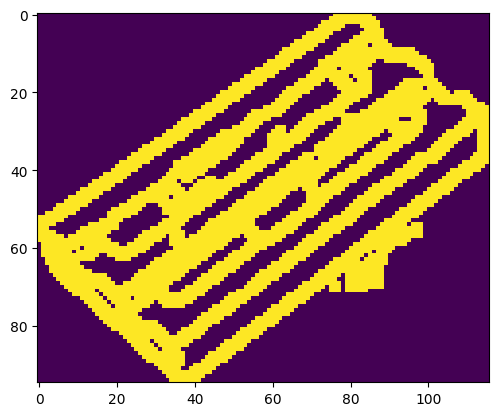

In [104]:
savedModel = model.load_weights('Weights2')
import cv2
def get_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #converting to gray scale
    gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

    #applying canny edge detection
    edged = cv2.Canny(gray, 10,100)

    #finding contours
    contours, _ = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    idx = 0
    for c in contours:
	    x,y,w,h = cv2.boundingRect(c)
	    if w>50 and h>50:
		    idx+=1
		    new_img=image[y:y+h,x:x+w]
    blurred = cv2.GaussianBlur(new_img, (1, 1), 0)
    edged = cv2.Canny(blurred,10, 100, apertureSize= 3)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilate = cv2.dilate(edged, kernel, iterations=1)
    return (dilate)
    #return image

test=get_image('test2.jpg')
img = img_to_array(test, dtype=np.float32)
print(test.shape)
plt.imshow(test)

test=resize_pad(img)
print(test.shape)
test = test.reshape((1,) + test.shape)
print(test.shape)
test = test_datagen.flow(test, batch_size=32, shuffle=False)

predictions=model.predict(test)
print(predictions)

pred=np.argmax(predictions)
print(labels[pred])
print(pred)